## Laboratory of Computational Physics mod. B
# Analysis of Belle2 MonteCarlo Data

__Authors:__

- Valeria Fioroni (University of Padova)
- Matteo Guida (University of Padova)
- Philipp Zehetner (University of Padova, Ludwig Maximilian University of Munich)

In [11]:
import os, sys, pprint
import glob
import pandas as pd
import numpy as np

from root_pandas import read_root

from random import seed
from random import randint

from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

from keras.utils import to_categorical

from sklearn.metrics import roc_auc_score
import xgboost as xgb
import warnings

import tensorflow as tf
from tensorflow import keras

In [2]:
Testing = True

In [3]:
# Define branches that we need for our analysis
Masses = ['B0_M', 'B0_ErrM', 'B0_SigM', 'B0_K_S0_M', 'B0_K_S0_ErrM', 'B0_K_S0_SigM', 'B0_etap_M', 'B0_etap_ErrM', 
          'B0_etap_SigM', 'B0_etap_eta_M', 'B0_etap_eta_ErrM', 'B0_etap_eta_SigM']
Kinetics_CMS = ['B0_Pcms', 'B0_etap_Pcms', 'B0_etap_eta_Pcms', 'B0_etap_eta_gamma0_Pcms', 'B0_etap_eta_gamma1_Pcms',
                'B0_etap_pi0_Pcms', 'B0_etap_pi1_Pcms', 'B0_K_S0_Pcms']
Other_Kinetics = ['B0_deltae', 'B0_mbc']
DecayAngles = ['B0_decayAngle__bo0__bc', 'B0_decayAngle__bo1__bc', 'B0_etap_decayAngle__bo0__bc',
               'B0_etap_decayAngle__bo1__bc', 'B0_etap_decayAngle__bo2__bc']
Positions = ['B0_X', 'B0_ErrX', 'B0_Y', 'B0_ErrY', 'B0_Z', 'B0_ErrZ', 'B0_Rho',  
             'B0_etap_X', 'B0_etap_ErrX', 'B0_etap_Y', 'B0_etap_ErrY', 
             'B0_etap_Z', 'B0_etap_ErrZ', 'B0_etap_Rho',
             'B0_etap_eta_X', 'B0_etap_eta_ErrX', 'B0_etap_eta_Y',
             'B0_etap_eta_ErrY', 'B0_etap_eta_Z', 'B0_etap_eta_ErrZ', 'B0_etap_eta_Rho',
             'B0_etap_pi0_X', 'B0_etap_pi0_ErrX', 'B0_etap_pi0_Y', 'B0_etap_pi0_ErrY', 
             'B0_etap_pi0_Z', 'B0_etap_pi0_ErrZ', 'B0_etap_pi0_Rho', 
             'B0_etap_pi1_X', 'B0_etap_pi1_ErrX', 'B0_etap_pi1_Y', 'B0_etap_pi1_ErrY', 
             'B0_etap_pi1_Z', 'B0_etap_pi1_ErrZ', 'B0_etap_pi1_Rho', 
             'B0_K_S0_X', 'B0_K_S0_ErrX', 'B0_K_S0_Y', 'B0_K_S0_ErrY', 'B0_K_S0_Z',
             'B0_K_S0_ErrZ', 'B0_K_S0_Rho', 
             'B0_cosAngleBetweenMomentumAndVertexVector', 'B0_distance', 'B0_significanceOfDistance',
             'B0_dr', 'B0_etap_pi0_dr', 'B0_etap_pi1_dr', 'B0_K_S0_dr']
Vertex_Training = ['B0_VtxPvalue', 'B0_etap_VtxPvalue', 'B0_etap_eta_VtxPvalue', 'B0_etap_pi0_VtxPvalue',
                   'B0_etap_pi1_VtxPvalue', 'B0_K_S0_VtxPvalue', ]
Continuum_Suppression_Training = ['B0_TrCSMVA']

Training = Kinetics_CMS + Masses + Other_Kinetics + Continuum_Suppression_Training + Positions + DecayAngles + Vertex_Training
Important = Training + ['B0_isSignal', 'evt_no']

In [4]:
def memory(df):
    print(str((round(df.memory_usage(deep=True).sum() / 1024 ** 2, 2))),"Mb")

In [5]:
path = '/home/utente/Scrivania/Progetto LCP-B/DataBelle2/'
SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
CFiles = glob.glob(os.path.join(path, 'Background/Continuum/*.root'))
PFiles = glob.glob(os.path.join(path, 'Background/Peaking/*.root'))

Signal = pd.concat((read_root(f, 'B0', columns=Important) for f in SFiles))
Signal = Signal[Signal['B0_isSignal']==1].reset_index(drop=True)
Continuum_bkg = pd.concat((read_root(f, 'B0', columns=Important) for f in CFiles))
Peaking_bkg = pd.concat((read_root(f, 'B0', columns=Important) for f in PFiles))

memory(Signal)
memory(Continuum_bkg)
memory(Peaking_bkg)

6.64 Mb
0.61 Mb
0.07 Mb


## Preselection

In [6]:
#Masses from PDG
M_B0 = [5.27955, 0.00026]
M_K0 = [0.497611, 0.000013]
M_etap = [0.95778, 0.00006]
M_eta = [0.547862, 0.000017]

#Require the B0 mass to be within 5 sigma from PDG value
Signal = Signal[abs(Signal['B0_M'] - M_B0[0]) < 5 * Signal['B0_ErrM']]
print(Signal.shape)

Continuum_bkg = Continuum_bkg[abs(Continuum_bkg['B0_M'] - M_B0[0]) < 5 * Continuum_bkg['B0_ErrM']]
print(Continuum_bkg.shape)

Peaking_bkg = Peaking_bkg[abs(Peaking_bkg['B0_M'] - M_B0[0]) < 5 * Peaking_bkg['B0_ErrM']]
print(Peaking_bkg.shape)

#Signal: In case of more than 1 candidate per event select the first one occuring
Mask_duplicated = Signal.duplicated(subset='evt_no', keep='first')
Mask_duplicated=np.logical_not(Mask_duplicated)
Signal=Signal[Mask_duplicated]
Signal.reset_index(drop=True, inplace=True)

print(Signal.shape)
print(Signal['evt_no'].nunique())

Signal=Signal[Training]
Continuum_bkg=Continuum_bkg[Training]
Peaking_bkg=Peaking_bkg[Training]

Signal['Type'] = 2
Continuum_bkg['Type'] = 1
Peaking_bkg['Type'] = 0

(19938, 85)
(908, 85)
(119, 85)
(19825, 85)
19825


## Preprocessing

In [7]:
n_seed=1234
seed(n_seed)

Split the dataset into 50% training set, 30% validation set and 20% test set.
While splitting the dataset we need to keep signal and different backgrounds separated in order to have the same, correct, fraction of "types" in each subset.

In [12]:
#SIGNAL: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Signal.drop('Type',axis=1)
Y = Signal['Type']
Y = label_binarize(Y, classes=[0, 1, 2]) # Binarize the labels
X_train_S, X_test_val_S, Y_train_S, Y_test_val_S = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_S
Y = Y_test_val_S
X_validation_S, X_test_S, Y_validation_S, Y_test_S = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_S)
del(Y_test_val_S)

#CONTINUUM BKG: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Continuum_bkg.drop('Type',axis=1)
Y = Continuum_bkg['Type']
Y = label_binarize(Y, classes=[0, 1, 2]) # Binarize the labels
X_train_C, X_test_val_C, Y_train_C, Y_test_val_C = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_C
Y = Y_test_val_C
X_validation_C, X_test_C, Y_validation_C, Y_test_C = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_C)
del(Y_test_val_C)

#PEAKING BKG: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Peaking_bkg.drop('Type',axis=1)
Y = Peaking_bkg['Type']
Y = label_binarize(Y, classes=[0, 1, 2]) # Binarize the labels
X_train_P, X_test_val_P, Y_train_P, Y_test_val_P = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_P
Y = Y_test_val_P
X_validation_P, X_test_P, Y_validation_P, Y_test_P = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_P)
del(Y_test_val_P)

del(Signal)
del(Peaking_bkg)
del(Continuum_bkg)


In [13]:
#Define Training, Validation and Test datasets
X_train=np.concatenate((X_train_S, X_train_C, X_train_P), axis=0)
X_validation=np.concatenate((X_validation_S, X_validation_C, X_validation_P), axis=0)
X_test=np.concatenate((X_test_S, X_test_C, X_test_P), axis=0)

Y_train=np.concatenate((Y_train_S, Y_train_C, Y_train_P), axis=0)
Y_validation=np.concatenate((Y_validation_S, Y_validation_C, Y_validation_P), axis=0)
Y_test=np.concatenate((Y_test_S, Y_test_C, Y_test_P), axis=0)

print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

print(X_train.nbytes/(1024 ** 2), "Mb")
print(X_validation.nbytes/(1024 ** 2), "Mb")
print(X_test.nbytes/(1024 ** 2), "Mb")
n_classes = Y_train.shape[1]


#shuffle the dataset
permutation = np.random.permutation(X_train.shape[0])
X_train = X_train[permutation]
Y_train = Y_train[permutation]

permutation = np.random.permutation(X_validation.shape[0])
X_validation = X_validation[permutation]
Y_validation = Y_validation[permutation]

permutation = np.random.permutation(X_test.shape[0])
X_test = X_test[permutation]
Y_test = Y_test[permutation]

(10425, 83)
(6255, 83)
(4172, 83)
3.300762176513672 Mb
1.9804573059082031 Mb
1.3209381103515625 Mb


## Feature scaling on the dataset
Center the points around their mean and scale them by their sample standard deviation. 
It seems that in general the algorithms of machine learning algorithms perform better after this kind of scaling.
Standardization of a dataset is a common requirement for many machine learning estimators: 
they might behave badly if the individual features do not more or less look like standard normally 
distributed data (e.g. Gaussian with 0 mean and unit variance). [More infos](https://scikit-learn.org/stable/modules/preprocessing.html)

In [15]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
X_validation = ss.transform(X_validation)

## XGBOOST
### Feature importance Xgboost 

In [18]:
Y_train_single_col=np.where(Y_train==1)[1]
Y_test_single_col=np.where(Y_test==1)[1]

In [19]:
#%%time
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

print("Training on %i examples with %i features"%X_train.shape)

#Use default parameters and train on full dataset
XGBclassifier = xgb.sklearn.XGBClassifier(nthread=-1, seed=1, n_estimators=1000,n_jobs = 1,objective = 'multi:softmax',silent=1,tree_method='approx')
#Train and time classifier
XGBclassifier.fit(X_train, Y_train_single_col)

#Make Predictions
print("Predicting on %i examples with %i features\n"%X_test.shape)
y_pred= XGBclassifier.predict(X_test)

#Print Results
print("Model Accuracy with all features: {:.2f}%".format(100*XGBclassifier.score(X_test, Y_test_single_col)))

Training on 10425 examples with 83 features
Predicting on 4172 examples with 83 features

Model Accuracy with all features: 99.38%


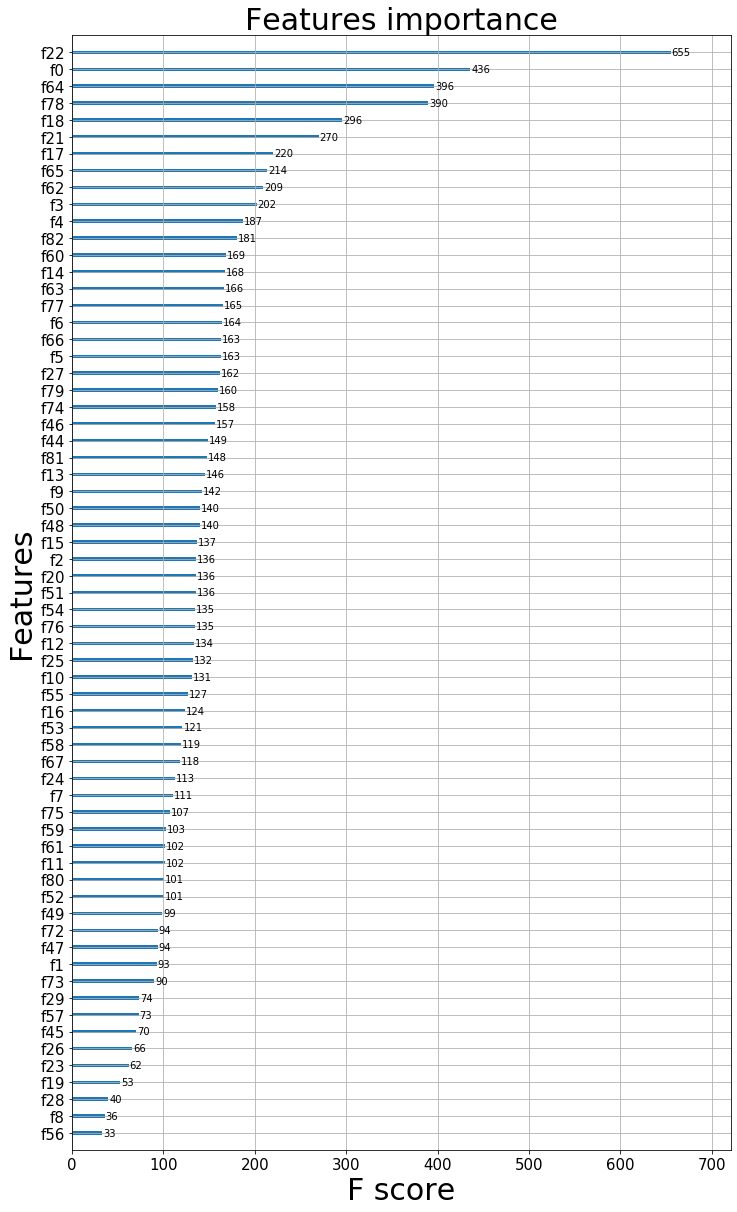

In [22]:
fig=plt.figure()
fig.set_size_inches(30.5, 20.5)
plt.tick_params(labelsize=15)
xgb.plot_importance(XGBclassifier, ax=plt.gca())
plt.title("Features importance",fontsize=30)
plt.ylabel("Features",fontsize=30)
plt.xlabel("F score",fontsize=30)
fig.subplots_adjust(left=0.6)  #
#fig.savefig('SUSYXGBoost1.pdf')

## Principal Component Analysis

11 variables explain 50% of the variance
35 variables explain 90% of the variance
41 variables explain 95% of the variance
50 variables explain 99% of the variance


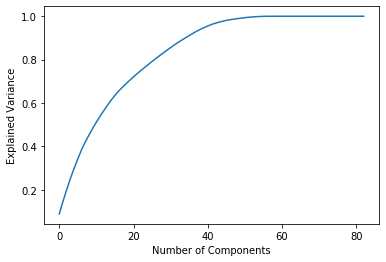

In [23]:
pca = PCA(n_components=len(Training))
pcTrain = pd.DataFrame(data = pca.fit_transform(X_train))
pcTest = pd.DataFrame(data = pca.transform(X_test))
pcValidation = pd.DataFrame(data = pca.transform(X_validation))

T50, T90, T95, T99, = False, False, False, False
for i in range(len(pca.explained_variance_ratio_)) : 
    if (sum(pca.explained_variance_ratio_[:i+1]) > 0.5 and T50 ==False) : 
        print(str(i+1) + ' variables explain 50% of the variance')
        T50 = True
        n_50 = i + 1 
    if (sum(pca.explained_variance_ratio_[:i+1]) > 0.9 and T90 ==False) : 
        print(str(i+1) + ' variables explain 90% of the variance')
        T90 = True
        n_90 = i + 1
    if (sum(pca.explained_variance_ratio_[:i+1]) > 0.95 and T95 ==False) : 
        print(str(i+1) + ' variables explain 95% of the variance')
        T95 = True
        n_95 = i + 1
    if (sum(pca.explained_variance_ratio_[:i+1]) > 0.99 and T99 ==False) : 
        print(str(i+1) + ' variables explain 99% of the variance')
        T99 = True
        n_99 = i + 1
        
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()

In [24]:
# For input_dim chose n_50, n_90, n_95 or n_99 depending on how much explained variance we require
input_dim = n_99
pcTrain = pcTrain.iloc[:, 0:input_dim]
pcTest = pcTest.iloc[:, 0:input_dim]
pcValidation = pcValidation.iloc[:, 0:input_dim]

## Create the Neural Network 

In [25]:
optimizer = ['SGD', 'Adam']
epochs = [10, 30]
epochs = [1, 2]
batch_size = [100, 1000]
architectures = [ [50, 50], [50, 100, 50], [50, 100, 100, 50] ] 
activation = ['relu', 'elu']

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasClassifier

def build_DNN(optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(pcTrain.shape[1],)))
    model.add(Dense(layers[0], input_shape=(pcTrain.shape[1],), activation='relu'))
    for i in range(1,len(layers)):
        model.add(Dense(layers[i], activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(3, activation='sigmoid'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def print_results() :
    print("Layers: ", layers)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params): 
        print("%f (%f) with %r" % (mean, stdev, param))


In [ ]:
from sklearn.model_selection import GridSearchCV

results = []
grids = []
for architecture in architectures : 
    layers = architecture
    print("Using architecture: ", layers)
    model = KerasClassifier(build_fn=build_DNN, batch_size=10000, epochs=2)
    param_grid = dict(epochs=epochs, batch_size=batch_size,
                      activation=activation, optimizer=optimizer)
    grid = GridSearchCV(estimator=model, param_grid=param_grid,
                        n_jobs=-1, pre_dispatch=8)
    grid_result = grid.fit(pcTrain, Y_train)
    results.append(grid_result)
    grids.append(grid)
    print_results()

Using architecture:  [50, 50]


/home/utente/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Epoch 1/2
10425/10425 [==============================] - 0s 43us/step - loss: 0.3649 - acc: 0.9246
Epoch 2/2
10425/10425 [==============================] - 0s 19us/step - loss: 0.1308 - acc: 0.9514
Layers:  [50, 50]
Best: 0.967002 using {'activation': 'relu', 'batch_size': 100, 'epochs': 2, 'optimizer': 'SGD'}
0.950791 (0.003055) with {'activation': 'relu', 'batch_size': 100, 'epochs': 1, 'optimizer': 'SGD'}
0.950791 (0.003055) with {'activation': 'relu', 'batch_size': 100, 'epochs': 1, 'optimizer': 'Adam'}
0.967002 (0.002641) with {'activation': 'relu', 'batch_size': 100, 'epochs': 2, 'optimizer': 'SGD'}
0.955875 (0.007038) with {'activation': 'relu', 'batch_size': 100, 'epochs': 2, 'optimizer': 'Adam'}
0.655731 (0.113205) with {'activation': 'relu', 'batch_size': 1000, 'epochs': 1, 'optimizer': 'SGD'}
0.721151 (0.285888) with {'activation': 'relu', 'batch_size': 1000, 'epochs': 1, 'optimizer': 'Adam'}
0.936403 (0.013869) with {'activation': 'relu', 'batch_size': 1000, 'epochs': 2, 'o

In [ ]:
for result in results : 
    pprint.pprint(result.best_score_)
    pprint.pprint(result.best_params_)